In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

# Find Communicative Successes and Failures 

In [ ]:
# Communicative success: how many no-xxx, no-yyy child  utterances are in Providence? 
# Communicative failures: how many one-yyy, no-xxx child utterances are in Providence?
# Subset to instances that are monosyllabic later

In [2]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [3]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA" \
    and corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [4]:
phono_glosses.corpus_name.value_counts()

Providence    396621
Name: corpus_name, dtype: int64

In [5]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*       26736
ə          10
(.)         7
aɪ          4
hiɡh        2
        ...  
ɪʔ          1
dʒeɪ        1
ɑdəʃ        1
eɪ          1
ɪs          1
Name: actual_phonology, Length: 76, dtype: int64

Actual phonology is almost always * for xxx items

In [6]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ         3206
ʌ         2132
ɪ         1881
ə          512
o          507
          ... 
aɪtɪ         1
wʊdidə       1
neɪ̃ŋ        1
dwɛdə        1
tɛðæ         1
Name: actual_phonology, Length: 30293, dtype: int64

Actual phonology is populated for yyy items

In [7]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [8]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [9]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [10]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [11]:
yyy_utts.shape

(31457, 3)

In [12]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [13]:
success_utts.shape

(83880, 3)

In [14]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [15]:
#exclude un-transcribed tokens and syllabically transcribed tokens
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [16]:
tokens_from_errorless_utts.shape

(214239, 12)

In [17]:
# example phonology
tokens_from_errorless_utts.actual_phonology

1          ɑmɪ
3          wiː
4          wiː
5           uː
52           ɛ
          ... 
396606       o
396607     waɪ
396608     liʔ
396609       ɪ
396610    hɪpo
Name: actual_phonology, Length: 214239, dtype: object

In [ ]:
# 31,457 transmission errors (from 31,457 utterances)
# 214,239 transmission successes (from 83,880 utterances)

# Prevalence of communication failures by age 

In [18]:
error_codes = ('xxx','yyy')

In [19]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

In [20]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [21]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



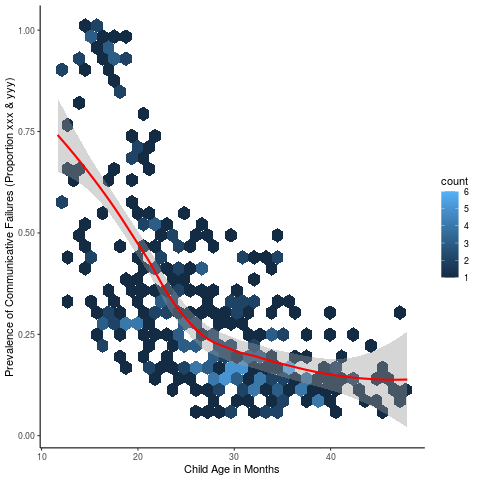

In [22]:
%%R 
ggplot(subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')) + geom_hex(aes(x=target_child_age_months, 
y=proportion_errors)) + theme_classic() + xlab('Child Age in Months') + ylab(
'Prevalence of Communicative Failures (Proportion xxx & yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors), color= 'red')

In [23]:
## why are there 0-prop ones so early? What are these transcripts?
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 20)
    & (error_prop_per_transcript.proportion_errors == 0) & (error_prop_per_transcript.num_tokens
    > 20 )]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name


In [24]:
chi_phono.loc[chi_phono.transcript_id == 41294]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months


In [25]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name
1,42205,0.957921,17.358607,404.0,Providence
3,42207,0.984102,18.422131,629.0,Providence
105,42309,0.987281,14.889344,629.0,Providence
106,42310,0.964765,15.723361,596.0,Providence
107,42311,0.972868,15.395492,774.0,Providence
108,42312,0.995136,15.821721,1028.0,Providence
270,42474,1.000000,14.430328,187.0,Providence
271,42475,1.000000,15.264344,278.0,Providence
272,42476,0.996466,15.821721,283.0,Providence
273,42477,1.000000,16.196721,72.0,Providence


In [ ]:
# Manually confirm that these transcripts indeed have a very high proportion of errors

# Load BERT Models + CMU Dict

### BERT models

In [31]:
from pytorch_pretrained_bert import BertForMaskedLM
from transformers import BertTokenizer # DO NOT load the one from pytorch_pretrained_bert;
# it does not support adding new vocabulary

In [27]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [32]:
# Off-the-shelf model
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask, adult_vocab = transfomers_bert_completions.get_softmax_mask(adult_tokenizer, cmu_2syl_inchildes.word)

# Fine-tuned model 
ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('model_output')
ft1_softmax_mask, ft1_vocab = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer, cmu_2syl_inchildes.word)

### Get the CMU Pronunciation Dictionary

In [ ]:
cmu_in_childes = pd.read_csv('phon/cmu_in_childes.csv')
cmu_2syl_inchildes = cmu_in_childes.loc[cmu_in_childes.num_vowels <=2]

# Prep Utterances / Tokens for BERT

In [33]:
# Get the index of the Providence corpus
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [34]:
# Load utterances from the Providence corpus from childs-db
regenerate = False
if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

In [35]:
# Prep the utterances for tokenization

# make compound words single words
def fix_gloss(gloss):
    # migt be better to split these glosses (black+bird -> black bird),but then we lose the alignment 
    return(str(gloss).replace('+','').replace('_',''))
utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

# add back punctuation from the utterance type
punct_for_type = {
    'question':'?',
    'declarative':'.',
    'self interruption':'.',
    'interruption':'!',
    'trail off':'...',
    'interruption question':'?',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}
utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else '.'
                        for x in utt_glosses.type ]

# add the speaker code (for compatibility with a fine-tuned model that has speaker identity)
utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

# build a single form that is appropriate for running through the tokenizer
utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower()+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(460061, 9)

In [36]:
utt_glosses[utt_glosses.id == 17280964]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
460056,oh why lick hippo,42569,17280964,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.


### Build the Vocabulary

In [37]:
# tokenize with the most extensive tokenizer
initial_tokenizer = BertTokenizer.from_pretrained('model_output2')
initial_tokenizer.add_tokens(['yyy','xxx']) #must maintain xxx and yyy for alignment,
# otherwwise, BERT tokenizer will try to separate these into x #x and #x and y #y #y
inital_vocab_mask, initial_vocab = transfomers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)

In [824]:
# confirm yyy treated as a separate character
initial_tokenizer.tokenize('this is a yyy.')

['this', 'is', 'a', 'yyy', '.']

In [38]:
cmu_in_initial_vocab = cmu_2syl_inchildes.loc[cmu_2syl_inchildes.word.isin(initial_vocab)]
cmu_in_initial_vocab.shape

(7904, 8)

In [40]:
# build a dataframe of tokens 
# this is slow, because tokenization is slow
def inflate (row):
    tokens = initial_tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = False
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [41]:
all_tokens.iloc[1]

Unnamed: 0                                             1
token                                              where
id                                              16759250
gloss                         where do you want me to go
transcript_id                                      42204
utterance_order                                        1
speaker_code                                         OPE
type                                            question
punct                                                  ?
speaker_code_simple                                [CGV]
gloss_with_punct       [CGV] where do you want me to go?
Name: 1, dtype: object

In [42]:
# Assign a token_id (integer in the BERT vocabulary). 
# Because these are from the tokenized utterances, there is no correpsondence 
# with childes-db token ids
all_tokens['token_id'] = initial_tokenizer.convert_tokens_to_ids(all_tokens['token'])
# assigns utterances a 0-indexed index column
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

### Add back IPA, syllable structure, and child ages for child productions

In [44]:
# get the token-level data, esp phonology
regenerate = False
if regenerate:

    # get token-level information for Providence
    pvd_chi_tokens = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order from token where speaker_code = "CHI" and corpus_id = '+str(pvd_idx),
        db_version = "2020.1")
    pvd_chi_tokens['gloss'] = [fix_gloss(x) for x in pvd_chi_tokens.gloss]
    
    # prep the tokens generated from segmenting the utterances
    all_tokens_test = copy.deepcopy(all_tokens) 

    # initialize the fields that need to be populated
    all_tokens_test['actual_phonology'] = ''
    all_tokens_test['model_phonology'] = ''
    all_tokens_test['target_child_age'] = np.nan
    
    # get a set of unique utterances
    _, idx = np.unique(all_tokens_test.id, return_index=True)
    all_utt_indices = all_tokens_test.id[np.sort(idx)]
    
    # For fast retrieval of IPA, split pvd_chi_tokens into a dictionary
    pvd_chi_tokens_list = pvd_chi_tokens.groupby(['utterance_id'])
    pvd_chi_tokens_dict = dict(zip(
        [x[0] for x in pvd_chi_tokens_list], 
        [x[1] for x in pvd_chi_tokens_list], 
    ))
    
    # For fast retrival of BERT tokenization
    all_tokens_test_list = all_tokens_test.groupby(['id'])
        all_tokens_test_dict = dict(zip(
        [x[0] for x in all_tokens_test_list], 
        [x[1] for x in all_tokens_test_list], 
    ))
        
    # Augment the tokens from all_tokens with the IPA from pvd_chi_tokens 
    rvs = [] 
    utts_to_retrieve = yyy_utts.utterance_id.to_list() + success_utts.utterance_id.to_list()
    i=-1
    for utt_index in all_utt_indices: #utts_to_retrieve: #[16760331]:       
        i+=1
        if i % int(len(all_utt_indices) / 100) == 0:
            print(str(np.round((i / (len(all_utt_indices)) * 100),2))+'% complete...')    
            # should learn to use tqdm instead
        if utt_index in utts_to_retrieve:        
            utt_df = copy.deepcopy(all_tokens_test_dict[utt_index])
            utt_df['model_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'model_phonology')
            utt_df['actual_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'actual_phonology')
            utt_df['target_child_age'] = pvd_chi_tokens_dict[utt_index].iloc[0].target_child_age    
            rvs.append(utt_df)  
        else:
            rvs.append(all_tokens_test_dict[utt_index])  
            
    # get the resulting augmented forms back into a dataframe
    all_tokens_phono = pd.concat(rvs)
    
    # add a unique identifier to the BERT tokens
    all_tokens_phono['bert_token_id'] = range(all_tokens_phono.shape[0])
    
    #save the results
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

R[write to console]: Using supported database version: '2020.1'.



In [46]:
# Inspect the IPA
all_tokens_phono.loc[all_tokens_phono.actual_phonology != ''][['token','actual_phonology','model_phonology']]

,token,actual_phonology,model_phonology
42,mommy,ɑmɪ,mɑmiː
81,yyy,ʌ,*
170,wee,wiː,wiː
173,yyy,aʊ,*
201,wee,wiː,wiː
...,...,...,...
3083590,nobody,nobɑɾi,noʊbɑdiː
3083591,hates,heɪs,heɪts
3083596,oh,o,oʊ
3083597,why,waɪ,waɪ


In [ ]:
# Get the IPA map
phone_map_df = pd.read_csv('phon/phon_map_populated.csv')
phone_map_df.head()

In [47]:
def phone_remap(x):
    return(x.replace("ː","").replace('ʌ','ə')
.replace('ɪ','ə').replace('ɔ','ɑ').replace('a','ɑ').replace('o','oʊ').replace('˞','').replace('ʰ',
    ''). replace('r','ɹ')).replace('\\^','').replace('\\ ̃','').replace(' ̩','').replace('^',''
).replace('ʙ','b').replace('(','').replace(')','').replace('.','').replace('ch','ʧ'
).replace('c','k').replace('g','ɡ').replace('y','j').replace('ʁ','ɹ')

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 
    'COMBINING GRAVE ACCENT', 'COMBINING TILDE', 'COMBINING VERTICAL LINE BELOW',
    'COMBINING SHORT STROKE OVERLAY')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

cv_map = dict(zip(phone_map_df['ipa'], phone_map_df['c_or_v']))
cv_map['o'] = 'v' 
cv_map['ɜ'] = 'v'
cv_map['e'] = 'v'
cv_map['ʔ'] = 'c'
cv_map['ɾ'] = 'c'
cv_map['ɲ'] = 'c'
cv_map['x'] = 'c'
cv_map['ɱ'] = 'c'
cv_map['ɣ'] = 'c'

def cv_mapper(x, cv_map):
    try:
        return(cv_map[x])
    except:
        raise ValueError(x)

regenerate = False
if regenerate:    

    # Do the same excludes as were used to identify appropriate utterances
    excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.isin(excludes),'actual_phonology'] =''
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.str.contains('V'),'actual_phonology'] =''
    
    # remap phonology from narrow phonetic transcription to broad phonological transcription
    all_tokens_phono['model_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['model_phonology']]
    all_tokens_phono['actual_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['actual_phonology']]

    # remove any non-combining diacritical marks
    all_tokens_phono['model_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['model_phonology_clean']]
    all_tokens_phono['actual_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['actual_phonology_clean']]
    
    # Compute the number of non-contiguous vowels.
    # slightly different than the cmu vowel computation ---
    # because here we are computing it directly from IPA
    all_tokens_phono['cv_raw'] = [''.join([cv_mapper(x, cv_map) for x in list(y)]) if y != '' else '' for y in all_tokens_phono['actual_phonology_no_dia']]    
    all_tokens_phono['cv_collapsed']  = [re.sub(r'(.)\1+', r'\1', str(x)) if x != '' else '' for x in all_tokens_phono['cv_raw']]
    all_tokens_phono['num_vowels'] = [np.sum(np.array(list(x)) == 'v') if x !='' else np.nan for x in all_tokens_phono['cv_collapsed']]
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')


In [826]:
all_tokens_phono.loc[all_tokens_phono.actual_phonology_no_dia != '']['actual_phonology_no_dia']

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


42             ɑmə
81               ə
170             wi
173             ɑʊ
201             wi
            ...   
3083590    noʊbɑɾi
3083591       heəs
3083596         oʊ
3083597        wɑə
3083598        liʔ
Name: actual_phonology_no_dia, Length: 254440, dtype: object

In [827]:
all_tokens_phono.shape

(3083627, 27)

### Identify the tokens that can be evaluated 

In [ ]:
# find the tokens in the resulting dataframe that belong to the utterances identified above

In [57]:
initial_vocab

array(['a', 'b', 'c', ..., 'hideout', 'pudding', 'stalks'], dtype='<U18')

In [59]:
successful_utt_ids = set(success_utts['utterance_id'])
initial_vocab_set = set(initial_vocab)
yyy_utt_ids = set(yyy_utts['utterance_id'])
all_tokens_phono['in_vocab'] = all_tokens_phono['token'].isin(initial_vocab_set)
all_tokens_phono['success_token'] = [x in successful_utt_ids for x in 
    all_tokens_phono['id']]
all_tokens_phono['yyy_token'] = [x in yyy_utt_ids for x in 
    all_tokens_phono['id']]

In [60]:
all_tokens_phono.shape

(3083627, 26)

### Identify the subset of success and failure utterances that have transcriptions

In [61]:
all_tokens_phono['partition'] = 'none'

In [62]:
success_tokens = all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2), 'partition'] = 'success'     
success_tokens.shape

(188212, 27)

In [63]:
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2)]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,...,actual_phonology_clean,model_phonology_no_dia,actual_phonology_no_dia,cv_raw,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,partition
42,mommy,16759315,Mommy,42204,6,CHI,declarative,.,[CHI],[CHI] mommy.,...,ɑmə,mɑmi,ɑmə,vcv,vcv,2.0,True,True,False,success
170,wee,16759467,wee,42204,24,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
201,wee,16759501,wee,42204,28,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
239,woo,16759549,woo,42204,33,CHI,declarative,.,[CHI],[CHI] woo.,...,u,wu,u,v,v,1.0,True,True,False,success
743,ernie,16759752,Ernie,42204,58,CHI,declarative,.,[CHI],[CHI] ernie.,...,ɛ,əɹni,ɛ,v,v,1.0,True,True,False,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083577,help,17280891,help,42569,752,CHI,declarative,.,[CHI],[CHI] help.,...,ɛlp,hɛlp,ɛlp,vcc,vc,1.0,True,True,False,success
3083591,hates,17280946,nobody hates Simba,42569,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.,...,heəs,heəts,heəs,cvvc,cvc,1.0,True,True,False,success
3083596,oh,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,oʊ,oʊʊ,oʊ,vv,v,1.0,True,True,False,success
3083597,why,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,wɑə,wɑə,wɑə,cvv,cv,1.0,True,True,False,success


In [64]:
yyy_tokens = all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2),'partition'] = 'yyy'
yyy_tokens.shape

(27693, 27)

In [65]:
all_tokens_phono.partition.value_counts()

none       2867722
success     188212
yyy          27693
Name: partition, dtype: int64

In [66]:
np.max(all_tokens_phono.token_id)

30525

# Prevalence of Successes and Failures Across Time

In [68]:
# get number of tokens per age
success_utts['set'] = 'success'
yyy_utts['set'] = 'failure'

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# get child age in days associated with each utterance id and plot it

In [67]:
utt_age = pvd_chi_tokens.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()

In [69]:
utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages

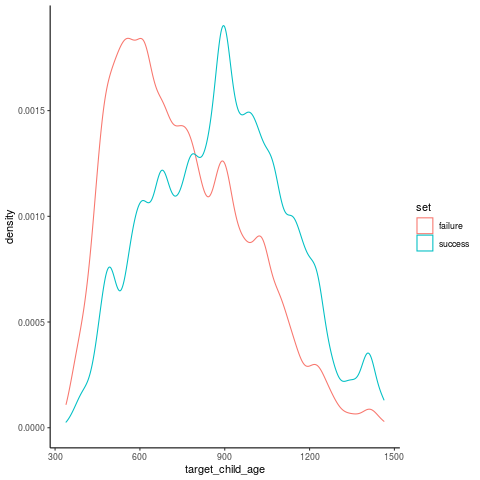

In [70]:
%%R
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()

In [ ]:
### Numver of utterances by Age

In [72]:
utts_with_ages['year'] = .5*np.floor(utts_with_ages['target_child_age'] / (365. /2) ) 
print(utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts())
print(utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts())

# Load a Set of Models

In [352]:
models = [
{'title': 'CHILDES BERT, +-20 utts context',
 'kwargs': {'modelLM': ft1_bertMaskedLM,
            'tokenizer': ft1_tokenizer,
            'softmax_mask': ft1_softmax_mask,
            'num_context_utts': 20,
            'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'CHILDES BERT, same utt only',
 'kwargs': {'modelLM': ft1_bertMaskedLM,
            'tokenizer': ft1_tokenizer,
            'softmax_mask': ft1_softmax_mask,
            'num_context_utts': 0,
            'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'Adult BERT, +-20 utts context',
'kwargs': {'modelLM': adult_bertMaskedLM,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'num_context_utts': 20,
           'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'Adult BERT, same utt only',
'kwargs': {'modelLM': adult_bertMaskedLM,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'num_context_utts': 0,
           'use_speaker_labels':False
           },
 'type': 'BERT'
},        
{'title': 'CHILDES Unigram',
'kwargs': {'child_counts_path': 'data/chi_vocab.csv',
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
},
{'title': 'Flat Unigram',
'kwargs': {'child_counts_path': None,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
}]

# Find the Best Value of $\beta$

In [995]:
# maximize the posterior by iterating over beta values
success_utts_for_beta_fitting = success_utts.sample(1000, replace=False).utterance_id
success_utts_for_beta_fitting

test_beta_vals = np.arange(2.5,3.5,.1)
beta_results = transfomers_bert_completions.sample_across_models(success_utts_for_beta_fitting, success_utts, yyy_utts, 
    all_tokens_phono, models[0:1], initial_vocab, cmu_in_initial_vocab, beta_values =
                     test_beta_vals)

beta_results_surp = beta_results.groupby(['beta_value']).posterior_surprisal.agg(lambda x: np.mean(-1 * np.log(x))
).reset_index()
%R -i beta_results_surp

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


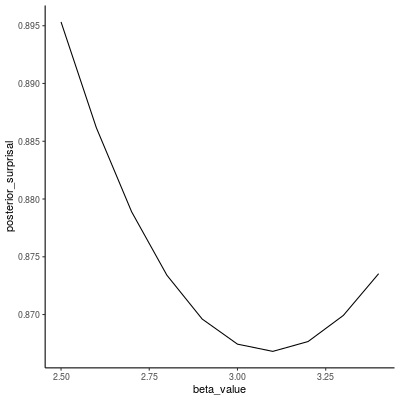

In [996]:
%%R -w 400 -h 400
ggplot(beta_results_surp) + geom_line(aes(x=beta_value, y=posterior_surprisal)) + theme_classic()

# Run Models Across Time

In [861]:
regenerate = False
if regenerate:
    scores_across_time = transfomers_bert_completions.sample_models_across_time(utts_with_ages, 
    all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab)
    scores_across_time.to_pickle('data/scores_across_time.pkl')
else:
    scores_across_time = pd.read_pickle('data/scores_across_time.pkl')

scores_across_time.set.value_counts()

In [998]:
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [999]:
%%R
# rename the models
model_levels = c("CHILDES BERT, +-20 utts context", "CHILDES BERT, same utt only", 
           "Adult BERT, +-20 utts context",  "Adult BERT, same utt only",
            "CHILDES Unigram", "Flat Unigram")
model_new_levels =  c("CHILDES BERT, +-20 utts context"="CDL+Context",
            "CHILDES BERT, same utt only" = "CDL+OneUtt",
          "Adult BERT, +-20 utts context" = "BERT+Context",
          "Adult BERT, same utt only" = "BERT+OneUtt",
            "CHILDES Unigram" = "CHILDES 1gram",
            "Flat Unigram" = "UniformPrior"
)
scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# Average Prior Surprisal

In [1000]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

          model prior_surprisal
1   CDL+Context        3.165968
2    CDL+OneUtt        5.276235
3  BERT+Context        4.587698
4   BERT+OneUtt        7.087848
5 CHILDES 1gram        8.803969
6  UniformPrior       12.948367


In [1001]:
%%R
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id  CDL+Context   CDL+OneUtt BERT+Context  BERT+OneUtt
1          1286          NaN          NaN          NaN          NaN
2          1529 0.0001056695 0.0050619622 0.0002259925 2.206714e-04
3          5564 0.1336800903 0.0003427833 0.0027237595 3.106821e-05
4          8051 0.7205283642 0.9667624235 0.5432096124 8.111445e-01
5          8052 0.9697376490 0.9924420118 0.9294804931 7.902554e-01
6          8053 0.7561864257 0.9565624595 0.5467512608 9.611819e-01
  CHILDES 1gram UniformPrior
1           NaN          NaN
2  0.0037258323 0.0001265182
3  0.0001606798 0.0001265182
4  0.0249223477 0.0001265182
5  0.0249223477 0.0001265182
6  0.0249223477 0.0001265182


In [1002]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

              CDL+Context CDL+OneUtt  BERT+Context  BERT+OneUtt CHILDES 1gram
CDL+Context            NA          0  0.000000e+00 0.000000e+00  0.000000e+00
CDL+OneUtt              0         NA  0.000000e+00 0.000000e+00  0.000000e+00
BERT+Context            0          0            NA 1.177664e-97 1.172517e-265
BERT+OneUtt             0          0  1.177664e-97           NA  0.000000e+00
CHILDES 1gram           0          0 1.172517e-265 0.000000e+00            NA
UniformPrior            0          0  0.000000e+00 0.000000e+00  0.000000e+00
              UniformPrior
CDL+Context              0
CDL+OneUtt               0
BERT+Context             0
BERT+OneUtt              0
CHILDES 1gram            0
UniformPrior            NA


### Posterior Surprisal Across Ages

In [1003]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age         model posterior_surprisal_mean posterior_surprisal_sem
1  0.5  BERT+Context                2.3319557              0.39670827
2  0.5   BERT+OneUtt                5.1606237              0.68772000
3  0.5   CDL+Context                1.2343716              0.27631901
4  0.5    CDL+OneUtt                3.3271563              0.52168239
5  0.5 CHILDES 1gram                3.6790926              0.51154137
6  0.5  UniformPrior                4.4973854              0.47833772
7  1.5  BERT+Context                1.7073404              0.10681821
8  1.5   BERT+OneUtt                3.0065727              0.13110062
9  1.5   CDL+Context                1.0648574              0.08537937
10 1.5    CDL+OneUtt                2.0572095              0.11009902
11 1.5 CHILDES 1gram                3.4367930              0.12629820
12 1.5  UniformPrior                4.2272941              0.11394814
13 1.0  BERT+Context                2.8155437              0.15158658
14 1.0   BERT+OneUtt

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,2.331956,0.396708
2,0.5,BERT+OneUtt,5.160624,0.687720
3,0.5,CDL+Context,1.234372,0.276319
4,0.5,CDL+OneUtt,3.327156,0.521682
5,0.5,CHILDES 1gram,3.679093,0.511541
6,0.5,UniformPrior,4.497385,0.478338
7,1.5,BERT+Context,1.707340,0.106818
8,1.5,BERT+OneUtt,3.006573,0.131101
9,1.5,CDL+Context,1.064857,0.085379
10,1.5,CDL+OneUtt,2.057209,0.110099


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


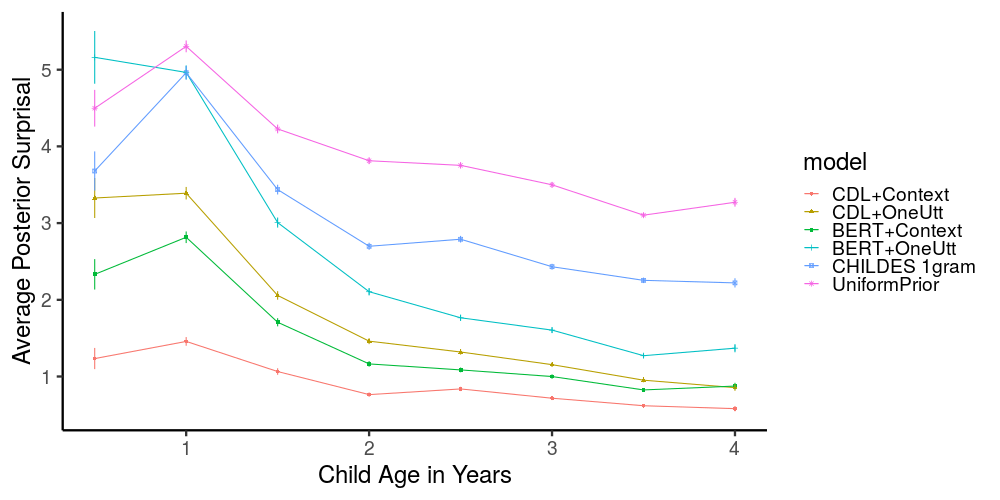

In [1004]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [895]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,5.348536,0.201515
2,0.5,BERT+OneUtt,9.231810,0.396100
3,0.5,CDL+Context,2.048350,0.178949
4,0.5,CDL+OneUtt,5.557589,0.274316
5,0.5,CHILDES Unigram,9.074144,0.096498
6,0.5,Flat Unigram,12.948367,0.000000
7,1.5,BERT+Context,5.105831,0.087803
8,1.5,BERT+OneUtt,8.669448,0.097730
9,1.5,CDL+Context,3.259259,0.076348
10,1.5,CDL+OneUtt,6.261301,0.080877


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


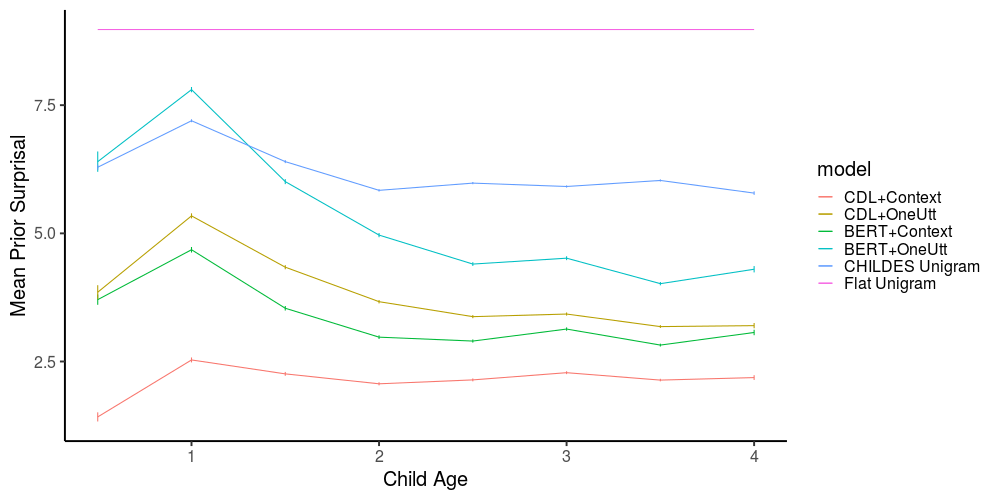

In [846]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [896]:
scores_across_time_short.set.value_counts()

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


success    89904
failure    33552
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [897]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,3.140225,0.082138
2,0.5,BERT+Context,success,1.321636,0.099834
3,0.5,BERT+OneUtt,failure,3.422119,0.078621
4,0.5,BERT+OneUtt,success,1.768958,0.111789
5,0.5,CDL+Context,failure,2.611891,0.093699
...,...,...,...,...,...
92,4.0,CDL+OneUtt,success,0.833137,0.033435
93,4.0,CHILDES Unigram,failure,2.854018,0.227300
94,4.0,CHILDES Unigram,success,2.079981,0.037202
95,4.0,Flat Unigram,failure,5.122522,0.232140


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


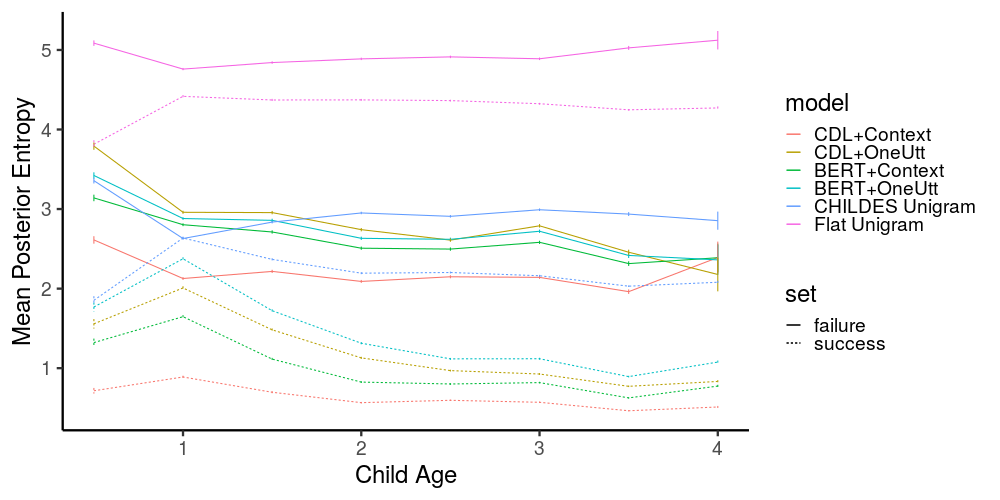

In [898]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# Information Gain 

In [1012]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [1013]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age         model      gain   gain_sem comparison age_in_months
1 0.5  BERT+Context 18.401410 0.33068583  posterior             6
2 0.5   BERT+OneUtt 19.458784 0.62006505  posterior             6
3 0.5   CDL+Context 24.795004 0.49328006  posterior             6
4 0.5    CDL+OneUtt 22.667585 0.78647474  posterior             6
5 0.5 CHILDES 1gram 17.298959 0.16667027  posterior             6
6 0.5  UniformPrior  9.104747 0.09739289  posterior             6


In [1015]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain   gain_sem comparison age_in_months
6  0.5 UniformPrior 9.104747 0.09739289  posterior             6
12 1.5 UniformPrior 8.741020 0.03969053  posterior            18
18 1.0 UniformPrior 8.550493 0.04450022  posterior            12
24 2.5 UniformPrior 8.911490 0.02985984  posterior            30
30 2.0 UniformPrior 8.889232 0.03297907  posterior            24
36 3.5 UniformPrior 9.024655 0.02758093  posterior            42
42 3.0 UniformPrior 8.963380 0.03216054  posterior            36
48 4.0 UniformPrior 9.124695 0.05074393  posterior            48


In [1027]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [1035]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

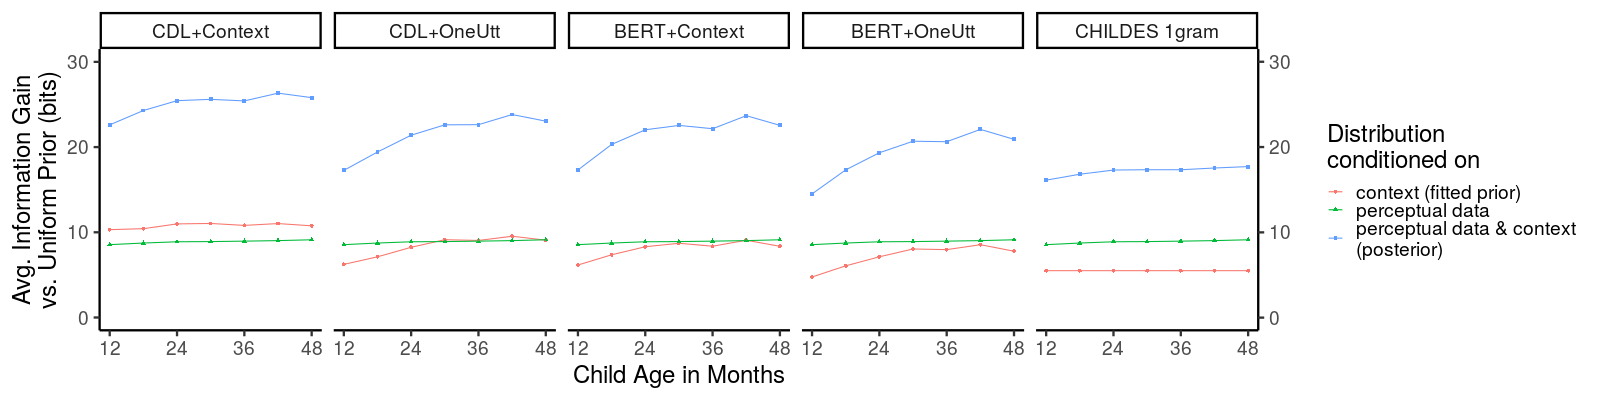

In [1036]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)

# Posterior Probability as a function of edit distance

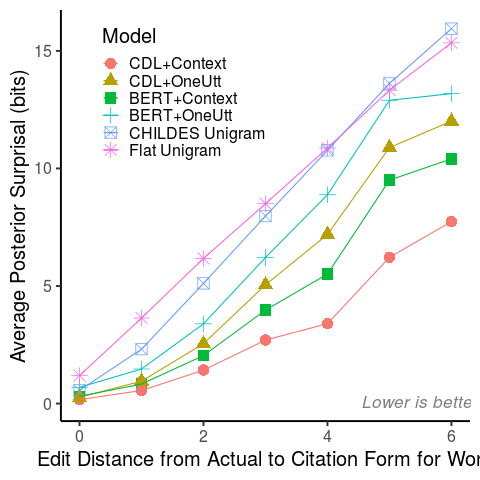

In [913]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/posterior_entropy_by_edit_distance_2.pdf', height=6, width=8)    
print(p1)

# ROC for Completions 

In [945]:
%%R
library(plotROC)

In [954]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 89904 33552


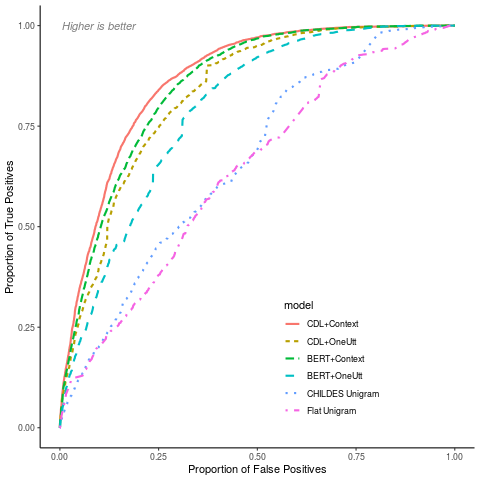

In [966]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model, linetype = model)
) + theme_classic()+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20)) + annotate("text",
label= "Higher is better", fontface="italic", x=.1, y=1, alpha =.5) 
print(p1)
ggsave('figures/roc_2.pdf', height=6, width=8)    

# Find Examples for the Table

### Find new test examples- successes

In [994]:
success_utts_with_gloss = success_utts.merge(utt_glosses[['id','gloss']], left_on=['utterance_id'], right_on=['id'])
success_utts_with_gloss['num_tokens'] = [len(x.split(' ')) for x in success_utts_with_gloss['gloss']]
' | '.join(success_utts_with_gloss.loc[success_utts_with_gloss.num_tokens ==4 ].gloss[0:100])

"pop pop pop pop | another one another one | I don't want to | apple apple apple apple | a red a pink | oh A B c | Mom what is that | a green a blue | beep beep beep beep | a b a b | one two three four | did you did you | one two one two | one two one two | b e a o | what is this two | no no no no | a cars a cars | a two a two | beep beep beep beep | one two one one | a tree a tree | way up over there | Mom Mommy Mom Mommy | where's Daddy where's Dada | hi Gigi hi Gigi | a ball a ball | a four a four | another one another one | mah mah mah mah | what's that what's this | what's that a ball | five five five five | no no Mommy no | mah muh mm mm | one one two three | a green a green | a green a green | a square a square | I did a square | another one another one | no no no no | no no no no | another one another one | a ball a ball | a ball a ball | red circle what's that | a ball a ball | a four a five | Mommy I did it | look at the green | Mommy can you fix | I try to push | Mommy help 

In [77]:
selected = success_utts_with_gloss.loc[success_utts_with_gloss.gloss=='I want to read'].utterance_id 

In [78]:
all_tokens_phono.columns

Index(['token', 'id', 'gloss', 'transcript_id', 'utterance_order',
       'speaker_code', 'type', 'punct', 'speaker_code_simple',
       'gloss_with_punct', 'token_id', 'seq_utt_id', 'actual_phonology',
       'model_phonology', 'target_child_age', 'bert_token_id',
       'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw',
       'cv_collapsed', 'num_vowels', 'in_vocab', 'success_token', 'yyy_token',
       'partition'],
      dtype='object')

In [79]:
selected

23653    16928243
24502    16933485
24597    16934000
31052    16962364
Name: utterance_id, dtype: int64

In [161]:
all_tokens_phono.loc[all_tokens_phono.id.isin(selected)][['gloss','actual_phonology_no_dia',
 'model_phonology_no_dia', 'id','bert_token_id','utterance_order','transcript_id']]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,gloss,actual_phonology_no_dia,model_phonology_no_dia,id,bert_token_id,utterance_order,transcript_id
1032327,I want to read,,,16928243,1032327,310,42336
1032328,I want to read,ɑə,ɑə,16928243,1032328,310,42336
1032329,I want to read,wɑn,wɑnt,16928243,1032329,310,42336
1032330,I want to read,də,tu,16928243,1032330,310,42336
1032331,I want to read,wid,ɹid,16928243,1032331,310,42336
1032332,I want to read,,,16928243,1032332,310,42336
1067443,I want to read,,,16933485,1067443,631,42336
1067444,I want to read,ɑə,ɑə,16933485,1067444,631,42336
1067445,I want to read,wɑn,wɑnt,16933485,1067445,631,42336
1067446,I want to read,də,tu,16933485,1067446,631,42336


In [238]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [318]:
scores_across_models = transfomers_bert_completions.sample_across_models([16928243], success_utts,
    yyy_utts, all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab, beta_values=[3.2])

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, no utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, no context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...


In [319]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'play (0.13) go (0.11) eat (0.06) see (0.05) talk (0.04) come (0.03) cry (0.02) hide (0.02) sleep (0.02) get (0.02)'

In [320]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'eat (0.21) see (0.16) weed (0.15) feed (0.1) read (0.06) walk (0.04) pee (0.03) wee (0.02) watch (0.02) hear (0.02)'

In [321]:
success_example = scores_across_models.loc[(scores_across_models.model == 'Adult BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'cry (0.21) scream (0.17) die (0.08) laugh (0.06) run (0.05) know (0.05) stay (0.02) smile (0.02) leave (0.02) vomit (0.01)'

In [322]:
words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'weep (0.6) feed (0.17) leave (0.06) be (0.02) win (0.01) eat (0.01) die (0.01) watch (0.01) laugh (0.01) see (0.01)'

In [323]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES Unigram') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'i (0.04) a (0.03) the (0.03) yeah (0.03) it (0.02) no (0.02) you (0.02) and (0.02) that (0.02) this (0.01)'

In [324]:
words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'we (0.34) need (0.11) and (0.06) would (0.04) wee (0.04) one (0.03) what (0.03) weed (0.02) he (0.02) me (0.02)'

In [325]:
 utt_glosses.loc[(utt_glosses.transcript_id == target_transcript_id) &
                (utt_glosses.utterance_order.isin(range(310-2, 310+2)))]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
168425,yyy yyy,42336,16928205,308,CHI,declarative,.,[CHI],[CHI] yyy yyy.
168445,you want mamma let's see,42336,16928225,309,MOT,declarative,.,[CGV],[CGV] you want mamma let's see.
168463,I want to read,42336,16928243,310,CHI,declarative,.,[CHI],[CHI] i want to read.
168481,okay mommy's gonna pick out a book,42336,16928261,311,MOT,declarative,.,[CGV],[CGV] okay mommy's gonna pick out a book.


### Find new Test Example -- Failures

In [326]:
yyy_utts_with_gloss = yyy_utts.merge(utt_glosses[['id','gloss']], left_on=['utterance_id'], right_on=['id'])
yyy_utts_with_gloss['num_tokens'] = [len(x.split(' ')) for x in yyy_utts_with_gloss['gloss']]
' | '.join(yyy_utts_with_gloss.loc[success_utts_with_gloss.num_tokens ==4 ].gloss)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy train | yyy | yyy | yyy | yyy where the pink | yyy | yyy | yyy | yyy heart | yyy | yyy | yyy | yyy | yyy | yyy | no yyy | yyy | yyy | yyy | yyy | yyy | green yellow red yyy | yyy | yyy | yyy | yyy | yyy | yyy Mommy | yyy | yyy | yyy | yyy no | yyy | yyy | a yyy | eight yyy three | yyy please | yyy | yyy | yyy | yyy egg | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy a blue | yyy | yyy Mommy | yyy | yyy three | yyy | yyy | yyy | yyy six | yyy | yyy | yyy | yyy | um yyy | yyy my Bob | yyy two | yyy | yyy | yyy | green ball yyy | yyy | yyy | yyy please scoot over | where's the flower and the yyy | yyy | yyy | yyy | yyy put it right there | yyy more | yyy color | yyy | yyy | oh yyy two three | yyy | yyy butterfly | where's Wiggle yyy | yyy where are you | yyy | where's the yyy | yyy | yyy | yyy | yyy | yyy see em | yyy | they match yyy | yyy | yyy | yyy | taking off my yyy off | yyy | yyy Gigi | they e

In [327]:
selected = yyy_utts_with_gloss.loc[yyy_utts_with_gloss.gloss=='you make your yyy'].utterance_id 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [328]:
all_tokens_phono.loc[all_tokens_phono.id.isin(selected)][['gloss','actual_phonology_no_dia',
 'model_phonology_no_dia', 'id','bert_token_id','utterance_order','transcript_id']]

,gloss,actual_phonology_no_dia,model_phonology_no_dia,id,bert_token_id,utterance_order,transcript_id
307933,you make your yyy,,,16813515,307933,112,42253
307934,you make your yyy,ju,ju,16813515,307934,112,42253
307935,you make your yyy,meək,meək,16813515,307935,112,42253
307936,you make your yyy,jɜ,jɑɹ,16813515,307936,112,42253
307937,you make your yyy,fɜt,*,16813515,307937,112,42253
307938,you make your yyy,,,16813515,307938,112,42253


In [329]:
scores_across_models = transfomers_bert_completions.sample_across_models( [16813515], success_utts,
    yyy_utts, all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab, beta_values=[3.2])

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, no utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, no context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...


In [330]:
scores_across_models

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank,prob,entropy,num_tokens_in_context,bert_token_id,set,posterior_entropy,prior_entropy,position_in_mask,kl_flat_to_prior,...,edit_distance,highest_posterior_words,highest_prior_words,highest_posterior_probabilities,highest_prior_probabilities,sample_index,beta_value,model,token,keep
307937,NaN,NaN,7.375654,6.0,307937.0,failure,3.123939,5.112414,NaN,NaN,...,NaN,feet hat own fit food bed mess way fat foot,own house bed mess way name tower head face br...,0.3463317245169062 0.13202393990779232 0.08789...,0.13597743 0.071731165 0.046943206 0.040938225...,0,3.2,"CHILDES BERT, 40 utts context",NaN,NaN
307937,NaN,NaN,7.375654,6.0,307937.0,failure,3.123939,5.112414,NaN,NaN,...,NaN,feet hat own fit food bed mess way fat foot,own house bed mess way name tower head face br...,0.3463317245169062 0.13202393990779232 0.08789...,0.13597743 0.071731165 0.046943206 0.040938225...,0,3.2,"CHILDES BERT, no utts context",NaN,NaN
307937,NaN,NaN,3.315662,6.0,307937.0,failure,3.679561,2.298241,NaN,NaN,...,NaN,move bet choice point own shot day cut bed call,choice point choices move own rounds day mark ...,0.13505124487938147 0.10169419593253419 0.0698...,0.3847465 0.2974154 0.09422047 0.03033365 0.01...,0,3.2,"Adult BERT, 40 utts context",NaN,NaN
307937,NaN,NaN,3.315662,6.0,307937.0,failure,3.679561,2.298241,NaN,NaN,...,NaN,move bet choice point own shot day cut bed call,choice point choices move own rounds day mark ...,0.13505124487938147 0.10169419593253419 0.0698...,0.3847465 0.2974154 0.09422047 0.03033365 0.01...,0,3.2,"Adult BERT, no context",NaN,NaN
307937,NaN,NaN,5.862046,NaN,307937.0,failure,3.809099,5.862046,NaN,NaN,...,NaN,it that fit what feet not foot get got put,i a the yeah it no you and that this,0.1528414008742849 0.1094394622717476 0.060582...,0.04169577290443618 0.03267180603396187 0.0277...,0,3.2,CHILDES Unigram,yyy,True
307937,NaN,NaN,8.975124,NaN,307937.0,failure,5.367228,8.975124,NaN,NaN,...,NaN,fought fit foot fat feet act sheet root sit met,stalks blake sad scent fur sessions refer rare...,0.07104101998497513 0.07104101998497513 0.0710...,0.00012651821862348178 0.00012651821862348178 ...,0,3.2,Flat Unigram,yyy,True


In [331]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'own (0.14) house (0.07) bed (0.05) mess (0.04) way (0.03) name (0.03) tower (0.03) head (0.02) face (0.02) breakfast (0.02)'

In [332]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'feet (0.35) hat (0.13) own (0.09) fit (0.04) food (0.04) bed (0.03) mess (0.03) way (0.02) fat (0.02) foot (0.01)'

In [333]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'Adult BERT, 40 utts context')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'choice (0.38) point (0.3) choices (0.09) move (0.03) own (0.01) rounds (0.01) day (0.01) mark (0.01) bed (0.01) call (0.01)'

In [334]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'move (0.14) bet (0.1) choice (0.07) point (0.05) own (0.05) shot (0.04) day (0.04) cut (0.04) bed (0.04) call (0.04)'

In [335]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES Unigram')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'i (0.04) a (0.03) the (0.03) yeah (0.03) it (0.02) no (0.02) you (0.02) and (0.02) that (0.02) this (0.01)'

In [336]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'it (0.15) that (0.11) fit (0.06) what (0.06) feet (0.05) not (0.04) foot (0.04) get (0.03) got (0.03) put (0.03)'

In [181]:
 utt_glosses.loc[(utt_glosses.transcript_id == 42253) &
                (utt_glosses.utterance_order.isin(range(112-3, 112+3)))]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
53679,then we won't be able to put them back into th...,42253,16813459,109,MOT,declarative,.,[CGV],[CGV] then we won't be able to put them back i...
53702,do you want ta put some beans in your eggs and...,42253,16813482,110,MOT,question,?,[CGV],[CGV] do you want ta put some beans in your eg...
53721,no,42253,16813501,111,CHI,declarative,.,[CHI],[CHI] no.
53735,you make your yyy,42253,16813515,112,CHI,declarative,.,[CHI],[CHI] you make your yyy.
53749,can I make one,42253,16813529,113,MOT,question,?,[CGV],[CGV] can i make one?
53774,no,42253,16813554,114,MOT,declarative,.,[CGV],[CGV] no.
